This notebook uses the correlations between the various assay datasets to combine them into a "tmprss2 equivalent" dataset.  The algorithm goes like this:
For each non-TMPRSS2 target:
1. Find the set S of chemicals which were assayed against both TMPRSS2 and the target protein
2. Manually remove outliers from S
3. Calculate spearman_r correlations between log(TMPRSS2 activity) and log(target activity).  Outliers are manually removed by inspection.
4. If spearman_r is high (>.70), perform a linear regression on S, x=TMPRSS2 activites, y=off-target activities.  Use the calculated slope to rescale the target's activity values.
5. Construct combined dataset

Combined Dataset Columns:

* **acvalue_target**: The activity as measured in the original assay, i.e. activity on "target"
* **active_target**: Whether acvalue_target is less than some threshold, defined in data processing notebooks (currently 50)
* **target**: The protein the assay was conducted on (e.g. ST14, TMPRSS2)
* **tmprss2_vs_target_spearman_r**: the spearman_r correlation from algorithm step 3
* **acvalue_scaled_to_tmprss2**: rescaled activity value from algorithm step 4
* **cid**: cid of compound
* **smiles**: smiles of compound


Note 1: spearman-r is used over pearson-r because our data has a skewed distribution.  See this article (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3576830/).  Note also that spearmanr(x, y) == spearmanr(log(x), log(y))

Note 2: the reason I only adjust by slope and not also by intercept is because adjusting by intercept could result in negative activities, which don't make sense.  Fixing intercept at 0 would solve this, but does not seem to be a reasonable assumption.  A near-zero activity on an off-target protein doesn't necessarily mean a near-zero activity on TMPRSS2.  In practice, the correlated off-targets have intercepts near zero, so this is not worth worrying about.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from scipy import stats

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
pd.set_option('display.width', 200)
pd.set_option('display.max_colwidth', 20)

In [2]:
# collect datasets
def load_ds(ds_name):
    return pd.read_pickle(f'../processed_data/{ds_name}_processed.pkl')
TMPRSS2 = load_ds('TMPRSS2')

off_targets = {ds_name: load_ds(ds_name) for ds_name in ['KLKB1', 'ST14', 'TMPRSS6', 'TMPRSS11D']}

In [3]:
# calculate overlaps
overlaps = {}
for name, off_target in off_targets.items():
    overlaps[name] = pd.merge(TMPRSS2, off_target, on='cid')
    print(f'{name}: num_overlaps={len(overlaps[name])}')

KLKB1: num_overlaps=1
ST14: num_overlaps=33
TMPRSS6: num_overlaps=30
TMPRSS11D: num_overlaps=20


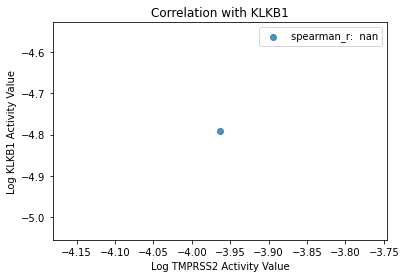

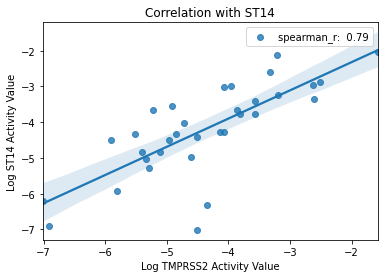

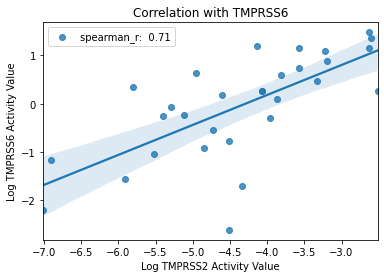

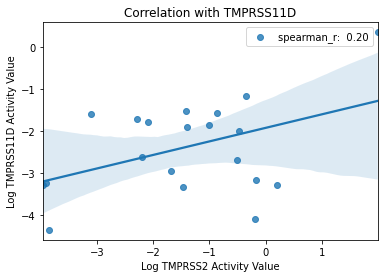

In [4]:
# visualize the overlap correlations
def visualize_overlaps(overlaps, square=False):
    for name, overlap in overlaps.items():
        plt.figure()
        x = np.log(overlap['acvalue_x'])
        y = np.log(overlap['acvalue_y'])
        try:
            sns.regplot(x, y, label=f'spearman_r: {spearmanr(x, y)[0]: .2f}')
        except ValueError:
            sns.regplot(x, y, label=f'spearman_r: undefined')
        plt.legend()
        plt.xlabel('Log TMPRSS2 Activity Value')
        plt.ylabel(f'Log {name} Activity Value')
        plt.title(f'Correlation with {name}')
        if square:
            xlim = plt.gca().get_xlim()
            ylim = plt.gca().get_ylim()
            lim = [min(xlim[0], ylim[0]), max(xlim[1], ylim[1])]
            plt.xlim(lim)
            plt.ylim(lim)
visualize_overlaps(overlaps)

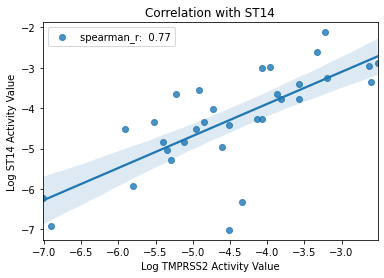

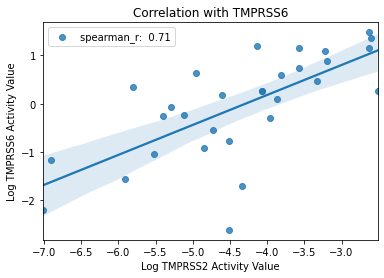

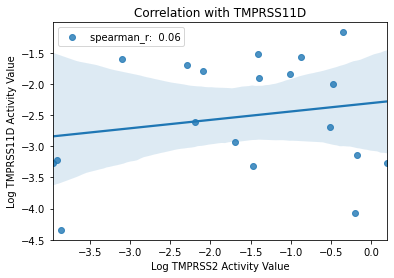

In [5]:
# manually drop outliers by inspection
cleaned_overlaps = {}
cleaned_overlaps['ST14'] = overlaps['ST14'][overlaps['ST14']['acvalue_x'] < .2]
cleaned_overlaps['TMPRSS6'] = overlaps['TMPRSS6'][overlaps['TMPRSS6']['acvalue_x'] < .2]
cleaned_overlaps['TMPRSS11D'] = overlaps['TMPRSS11D'][overlaps['TMPRSS11D']['acvalue_x'] < 7]

visualize_overlaps(cleaned_overlaps)

A summary of the off-targets:
1. KLKB1 has insufficient data to determine correlation
2. ST14 has a strong correlation with TMPRSS2
3. TMPRSS6 has a strong correlation with TMPRSS2
4. TMPRSS11D has no correlation with TMPRSS2

We will thus only bother with scaling ST14 and TMPRSS6.

Note: not only are there no overlaps between KLKB1 and TMPRSS2, there's no overlaps betwen KLKB1 and any of the other targets!  So we can't even try to do a transitive correlation.  See following cell:

In [6]:
# calculate overlaps between KLKB1 and other targets
KLKB1_overlaps = {}
for name, off_target in off_targets.items():
    if name != 'KLKB1':
        KLKB1_overlaps[name] = pd.merge(off_targets['KLKB1'], off_target, on='cid')
        print(f'{name}: num_overlaps={len(KLKB1_overlaps[name])}')

ST14: num_overlaps=2
TMPRSS6: num_overlaps=1
TMPRSS11D: num_overlaps=0


Before Scaling


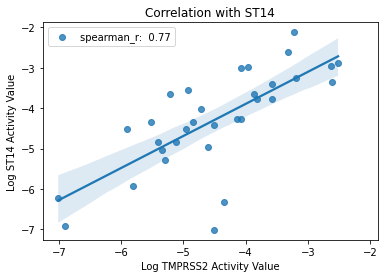

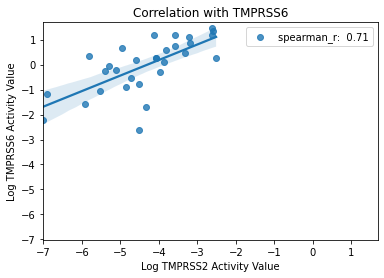

In [7]:
# scaling
print('Before Scaling')
visualize_overlaps({name: cleaned_overlaps[name] for name in ['ST14', 'TMPRSS6']}, square=True)

After Scaling


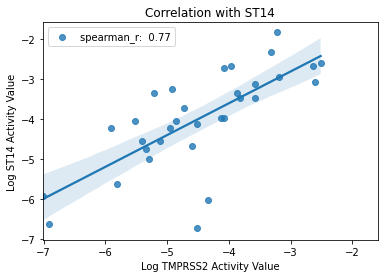

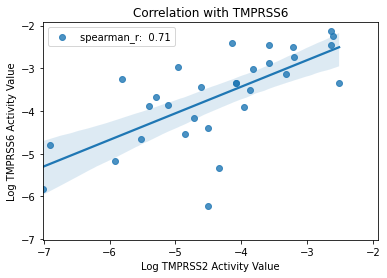

In [8]:
regression_slopes = {'KLKB1': np.nan, 'TMPRSS11D': np.nan}
scaled_overlaps = {}
for name in ['ST14', 'TMPRSS6']:
    overlap = cleaned_overlaps[name].copy()
    x = overlap['acvalue_x']
    y = overlap['acvalue_y']
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    regression_slopes[name] = slope
    
    scaled_overlaps[name] = overlap
    scaled_overlaps[name]['acvalue_y'] /= slope
print('After Scaling')
visualize_overlaps(scaled_overlaps, square=True)

In [9]:
# calculate spearman_rs
spearman_rs = {}
cleaned_overlaps
for name, overlap in cleaned_overlaps.items():
    spearman_rs[name] = spearmanr(overlap['acvalue_x'], overlap['acvalue_y'])[0]
spearman_rs['KLKB1'] = np.nan

In [10]:
# Finally, construct the combined dataset
orig_datasets = off_targets
orig_datasets['TMPRSS2'] = TMPRSS2

spearman_rs['TMPRSS2'] = 1
regression_slopes['TMPRSS2'] = 1

reformatted_datasets = []
for target in ['TMPRSS2', 'KLKB1', 'ST14', 'TMPRSS6', 'TMPRSS11D']:
    ds = orig_datasets[target].copy()
    ds = ds.rename(columns={'acvalue': 'acvalue_target', 'activity': 'activity_target', 'morgan_fp': 'morgan_fingerprint'})
    ds['target'] = target
    ds['acvalue_scaled_to_tmprss2'] = ds['acvalue_target'] / regression_slopes[target]
    ds['tmprss2_vs_target_spearman_r'] = spearman_rs[target]
    reformatted_datasets.append(ds)

combined_dataset = pd.concat(reformatted_datasets)

In [11]:
# reorder columns
combined_dataset = combined_dataset[['acvalue_target', 'activity_target', 'target', 'tmprss2_vs_target_spearman_r', 'acvalue_scaled_to_tmprss2', 'cid', 'morgan_fingerprint']]
combined_dataset.head()

,acvalue_target,activity_target,target,tmprss2_vs_target_spearman_r,acvalue_scaled_to_tmprss2,cid,morgan_fingerprint
0,0.019,Active,TMPRSS2,1.0,0.019,46899577,"[0, 1, 0, 0, 0, ..."
1,0.019,Active,TMPRSS2,1.0,0.019,56677005,"[0, 1, 0, 0, 0, ..."
2,0.020,Active,TMPRSS2,1.0,0.020,49835415,"[0, 1, 0, 0, 0, ..."
3,0.021,Active,TMPRSS2,1.0,0.021,49835557,"[0, 1, 0, 0, 0, ..."
4,0.044,Active,TMPRSS2,1.0,0.044,0,"[0, 1, 0, 0, 0, ..."


In [12]:
combined_dataset.shape

(895, 7)

In [13]:
combined_dataset = combined_dataset.reset_index(drop=True)

In [15]:
# save file to disk
combined_dataset.to_pickle('../processed_data/combined_dataset.pkl')

#### Example: how to recover dataframe from saved file

In [16]:
df_loaded = pd.read_pickle('../processed_data/combined_dataset.pkl')

In [17]:
df_loaded.head()

,acvalue_target,activity_target,target,tmprss2_vs_target_spearman_r,acvalue_scaled_to_tmprss2,cid,morgan_fingerprint
0,0.019,Active,TMPRSS2,1.0,0.019,46899577,"[0, 1, 0, 0, 0, ..."
1,0.019,Active,TMPRSS2,1.0,0.019,56677005,"[0, 1, 0, 0, 0, ..."
2,0.020,Active,TMPRSS2,1.0,0.020,49835415,"[0, 1, 0, 0, 0, ..."
3,0.021,Active,TMPRSS2,1.0,0.021,49835557,"[0, 1, 0, 0, 0, ..."
4,0.044,Active,TMPRSS2,1.0,0.044,0,"[0, 1, 0, 0, 0, ..."


In [18]:
# demonstration that fingerprint is loaded correctly
print("Fingerprint type:", type(df_loaded.morgan_fingerprint.iloc[0]))
print("Fingerprint length:", df_loaded.morgan_fingerprint.iloc[0].shape)
print("First fingerprint equal:", np.all(df_loaded.morgan_fingerprint.iloc[0] == combined_dataset.morgan_fingerprint.iloc[0]))

Fingerprint type: <class 'numpy.ndarray'>
Fingerprint length: (2048,)
First fingerprint equal: True
